# Rolling Ratings for 10 game sample

In [1]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

fig_DIR = "../figs/teams/"
box_DIR = "../data/box/"

In [2]:
year = 2024
df1 = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{year}.parquet")
df1 = df1.rename(
        columns={
            "offensiveRating": "ORtg",
            "defensiveRating": "DRtg",
            "netRating": "NRtg",
            "possessions": "poss",
        }
)
cols = ["gameId", "teamId", "ORtg", "DRtg", "NRtg", "poss"]
df1 = df1[cols]
df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{year}.parquet")
df2 = df2.rename(
    columns={
        "GAME_ID": "gameId",
        "TEAM_ID": "teamId",
        "TEAM_ABBREVIATION": "teamTricode",
        "GAME_DATE": "gameDate",
        "TEAM_NAME": "teamName",
    }
)
cols2 = ["gameId", "teamId", "teamTricode", "gameDate"]
df2 = df2[cols2]
df2["gameId"] = df2["gameId"].astype(int)
df3 = pd.merge(df2, df1, on=["gameId", "teamId"])
df3 = df3.rename(columns={"gameDate": "Date"})
df3["Date"] = pd.to_datetime(df3["Date"], format="%Y-%m-%d")
df4 = df3.sort_values(by=["teamTricode", "Date"]).reset_index(drop=True)
teams = df4["teamTricode"].unique()
df4g = df4.groupby("teamTricode")
team = teams[0]
df6 = []
for team in teams:
    df5 = df4g.get_group(team)
    df5[["rORtg","rDRtg","rNRtg"]] = df5[["ORtg","DRtg","NRtg"]].rolling(10,min_periods=1).mean()
    df5[["rORtg","rDRtg","rNRtg"]] = df5[["rORtg","rDRtg","rNRtg"]].round(1)
    df6.append(df5)
df6 = pd.concat(df6)
df_teams = pd.read_csv("../data/NBA_teams_colors_logos.csv")
df_teams = df_teams.rename(columns={"nameTeam": "Team"})
df7 = pd.merge(df6, df_teams)
data = df7
data["teamDup"] = data["teamTricode"]
data1 = data.copy().drop(columns=["teamTricode"])

In [ ]:
team = "TOR"
data2 = data[data["teamTricode"] == team].reset_index(drop=True)

var = "NRtg"
title = data2["Team"][0] + " Net Rating 2023-24"
subtitle = "League Avg is red | Trend line estimated using local regression"

p = (
    ggplot(data2)
    # + geom_smooth(
    #     data=data1,
    #     mapping=aes(x="Date", y=var, group="teamDup"),
    #     method="loess",
    #     color="lightgrey",
    #     se=False,
    #     size=0.5,
    # )
    + geom_smooth(
        aes(x="Date", y=var, group="teamTricode"),
        # method="loess",
        color="Black",
        se=False,
        span=0.5
    )
    + geom_point(
        aes(x="Date", y=var, group="teamTricode"),
        color="Black",
    )
    # + geom_smooth(data= data_avg,mapping=aes(x="Date", y=var,group = "teamDup"),method="loess",color="red", se=False, size=0.5)
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=0.5)
    # + ylim(-10, 10)
    + scale_x_date(date_labels="%b-%d", date_breaks="2 week")
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[-10,10])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
    )
    + theme_idv
)
p.save(fig_DIR + "Rolling_" + var + "_" + team + ".png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
data.head()

# League Average Trend Line

In [3]:
df9 = df4.copy()
df9 = df9.query("poss > 0")
df9["OPts"] = df9["ORtg"]*df9["poss"]

In [4]:
dg = df9.groupby("Date")[["OPts","poss"]].sum()
dg = dg.reset_index()
dg["ORtg"] = round(dg["OPts"]/dg["poss"],2)
dg1 = df9.groupby("Date")[["poss"]].mean()
dg1 = dg1.reset_index()

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/rolling_ORtg_league_avg_last.png


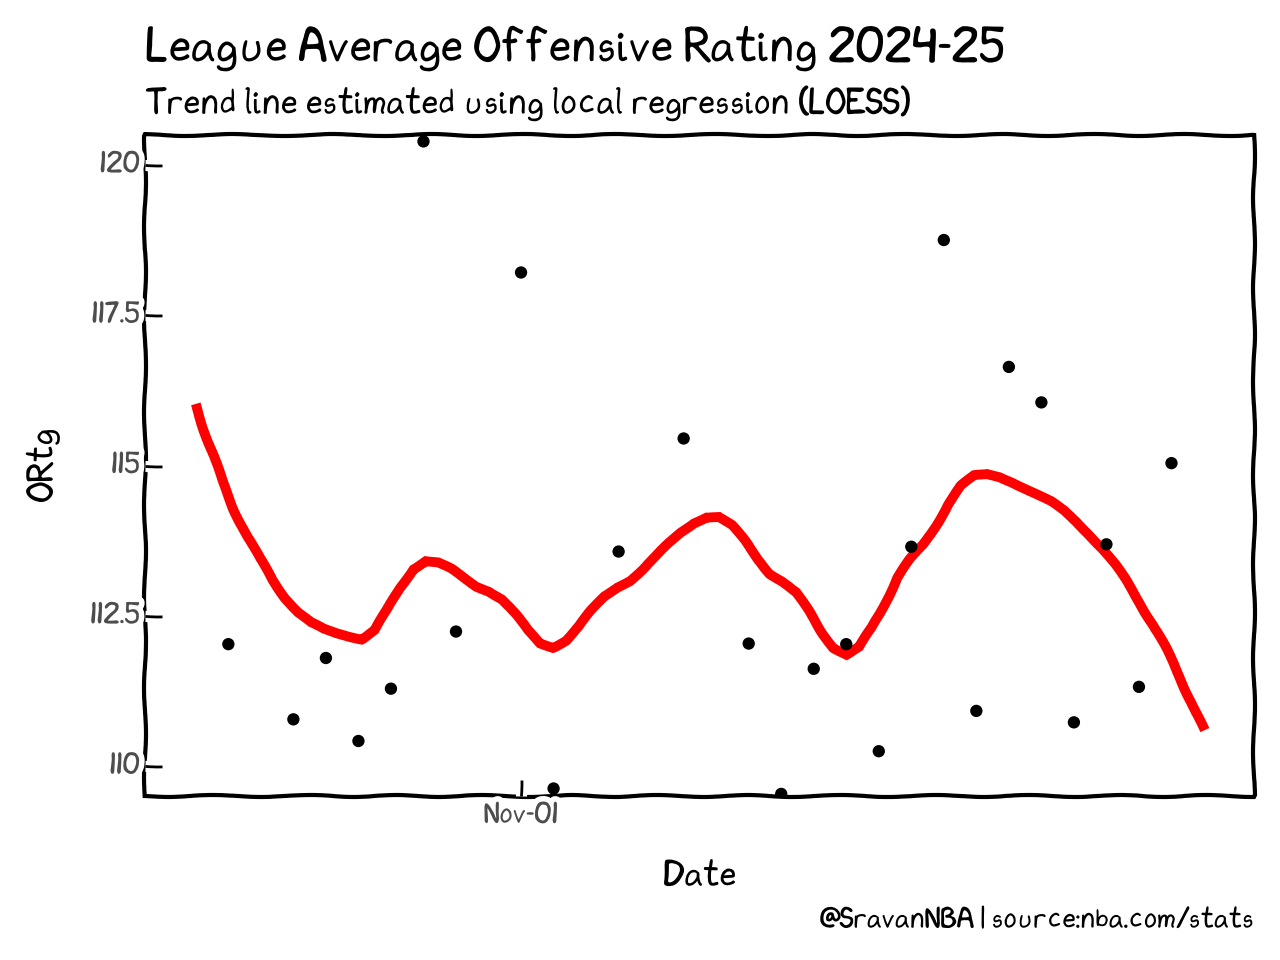

In [5]:
var = "ORtg"
title = "League Average Offensive Rating 2024-25"
subtitle = "Trend line estimated using local regression (LOESS)"

p = (
    ggplot(dg)
    + geom_smooth(
        aes(x="Date", y=var, group=0),
        # method="loess",
        color="red",
        se=False,
        span=0.5,
        size=2,
    )
    + geom_point(
        aes(x="Date", y=var, group=0),
        color="Black",
    )
    # + ylim(-10, 10)
    + scale_x_date(date_labels="%b-%d", date_breaks="1 month")
    + coord_cartesian(ylim=[110,120])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
    )
    + theme_idv
    + theme(
        plot_margin=0.02
    )
)
p.save(fig_DIR + "rolling_ORtg_league_avg_last.png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
var = "poss"
title = "League Average Pace 2023-24"
subtitle = "Trend line estimated using local regression (LOESS)"

p = (
    ggplot(dg1)
    + geom_smooth(
        aes(x="Date", y=var, group=0),
        # method="loess",
        color="red",
        se=False,
        span=0.5,
        size=2,
    )
    + geom_point(
        aes(x="Date", y=var, group=0),
        color="Black",
    )
    # + ylim(90, 110)
    + scale_x_date(date_labels="%b-%d", date_breaks="1 month")
    + coord_cartesian(ylim=[95,105])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
    )
    + theme_idv
    + theme(
        plot_margin=0.02
    )
)
p.save(fig_DIR + "rolling_Poss_league_avg_last.png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
dfp = df4.copy()
dfp = dfp.query("poss > 0")
dfp1 = dfp[dfp["Date"]<"2024-02-01"]
dfp1["cat"] = "Before"
dfp2 = dfp[dfp["Date"]>"2024-01-31"]
dfp2["cat"] = "After"
dfp3 = pd.concat([dfp1,dfp2])

In [ ]:
var = "NRtg"
title = "Net Rating Distribution Before and After Jan 31, 2024"
subtitle = "Trend line estimated using local regression (LOESS)"

p = (
    ggplot(dfp3)  # What data to use
    + aes(x=var, group="cat", fill="cat")  # What variable to use
    + geom_density(
            alpha=0.8,
            # show_legend=False,
        )
    + scale_fill_manual(values=["blue","red"])
    + coord_cartesian(xlim=[-30,30])
    #  + coord_cartesian(xlim=[80,150])
    + labs(
        x=var,
        y="Frequency",
        title=title,
        subtitle="x-axis shows the points and y-axis shows fraction of games",
        caption="@sradjoker | source: nba.com/stats",
    )
    + theme_idv
    + theme(
        plot_margin=0.02,
        legend_title=element_blank()
    )
)
p.save(fig_DIR + "net_rat_var_bf_af.png", width=6, height=5, dpi=300)
p.draw()

# Comparing trends across seasons

## ORTG

In [ ]:
dfa = []
for year in range(2019,2024):
    df1 = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{year}.parquet")
    df1 = df1.rename(
            columns={
                "offensiveRating": "ORtg",
                "defensiveRating": "DRtg",
                "netRating": "NRtg",
                "possessions": "poss",
            }
    )
    cols = ["gameId", "teamId", "ORtg", "DRtg", "NRtg", "poss"]
    df1 = df1[cols]
    df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{year}.parquet")
    df2 = df2.rename(
        columns={
            "GAME_ID": "gameId",
            "TEAM_ID": "teamId",
            "TEAM_ABBREVIATION": "teamTricode",
            "GAME_DATE": "gameDate",
            "TEAM_NAME": "teamName",
        }
    )
    cols2 = ["gameId", "teamId", "teamTricode", "gameDate"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    df3 = pd.merge(df2, df1, on=["gameId", "teamId"])
    df3 = df3.rename(columns={"gameDate": "Date"})
    df3["Date"] = pd.to_datetime(df3["Date"], format="%Y-%m-%d")
    df4 = df3.sort_values(by=["teamTricode", "Date"]).reset_index(drop=True)
    df4["season"] = year + 1
    df9 = df4.copy()
    df9["OPts"] = df9["ORtg"]*df9["poss"]
    dg = df9.groupby("Date")[["OPts","poss"]].sum()
    dg = dg.reset_index()
    dg["ORtg"] = round(dg["OPts"]/dg["poss"],2)
    dg["season"] = year + 1
    dg = dg.reset_index()
    dg = dg[["index","ORtg","season"]]
    dg["index"]+=1
    dfa.append(dg)
dfa = pd.concat(dfa)

In [ ]:
dfa["Season"] = dfa["season"].astype("category")

In [ ]:
colors = [
    '#0057e7',
    '#008744',
    '#ffa700',
    '#4d1b7b',
    '#d62d20',
    '#9AA0A6',
]

In [ ]:
var = "ORtg"
title = "League Average Offensive Rating"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfa)
    + geom_smooth(
        aes(x="index", y=var, group="Season",color="Season"),
        se=False,
        span=0.5,
        size=2,
    )
    + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_ORtg_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()

## FTA, Fouls

In [ ]:
year = 2023
df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{year}.parquet")

In [ ]:
dfb = []
for year in range(2019,2024):
    df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{year}.parquet")
    df2 = df2.rename(
        columns={
            "GAME_ID": "gameId",
            "TEAM_ID": "teamId",
            "TEAM_ABBREVIATION": "teamTricode",
            "GAME_DATE": "gameDate",
            "TEAM_NAME": "teamName",
        }
    )
    cols2 = ["gameId", "teamId", "teamTricode", "gameDate","PF","FTA","FTM","PTS"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    df3 = df2.rename(columns={"gameDate": "Date"})
    df3["Date"] = pd.to_datetime(df3["Date"], format="%Y-%m-%d")
    df4 = df3.sort_values(by=["teamTricode", "Date"]).reset_index(drop=True)
    df4["PTS_wo_FT"]=df4["PTS"]-df4["FTM"]
    df9 = df4.copy()
    dg = df9.groupby("Date")[["PF","FTA","PTS","PTS_wo_FT"]].mean()
    dg = dg.reset_index()
    dg["season"] = year + 1
    dg = dg.reset_index()
    dg = dg[["index","PF","FTA","PTS","PTS_wo_FT","season"]]
    dg["index"]+=1
    dfb.append(dg)
dfb = pd.concat(dfb)
dfb["Season"] = dfb["season"].astype("category")

In [ ]:
var = "PF"
title = "League Average Fouls per Game"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfb)
    + geom_smooth(
        aes(x="index", y=var, group="Season",color="Season"),
        se=False,
        span=0.5,
        size=2,
    )
    + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day",
        y = "Personal Fouls"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_fouls_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
var = "FTA"
title = "League Average FTA per Game"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfb)
    + geom_smooth(
        aes(x="index", y=var, group="Season",color="Season"),
        se=False,
        span=0.5,
        size=2,
    )
    + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day",
        y = "Free Throw Attempts"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_FTA_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
var = "PTS_wo_FT"
title = "Points without FTs per Game"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfb)
    + geom_smooth(
        aes(x="index", y=var, group="Season",color="Season"),
        se=False,
        span=0.5,
        size=2,
    )
    + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day",
        y = "PTS wo FTs"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_PTS_wo_FT_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()

## PACE

In [ ]:
dfa = []
for year in range(2019,2024):
    df1 = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{year}.parquet")
    df1 = df1.rename(
            columns={
                "offensiveRating": "ORtg",
                "defensiveRating": "DRtg",
                "netRating": "NRtg",
                "possessions": "poss",
            }
    )
    cols = ["gameId", "teamId", "ORtg", "DRtg", "NRtg", "poss"]
    df1 = df1[cols]
    df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{year}.parquet")
    df2 = df2.rename(
        columns={
            "GAME_ID": "gameId",
            "TEAM_ID": "teamId",
            "TEAM_ABBREVIATION": "teamTricode",
            "GAME_DATE": "gameDate",
            "TEAM_NAME": "teamName",
        }
    )
    cols2 = ["gameId", "teamId", "teamTricode", "gameDate"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    df3 = pd.merge(df2, df1, on=["gameId", "teamId"])
    df3 = df3.rename(columns={"gameDate": "Date"})
    df3["Date"] = pd.to_datetime(df3["Date"], format="%Y-%m-%d")
    df4 = df3.sort_values(by=["teamTricode", "Date"]).reset_index(drop=True)
    df4["season"] = year + 1
    df9 = df4.copy()
    df9 = df9.query("poss > 0")
    dg = df9.groupby("Date")[["poss"]].mean()
    dg = dg.reset_index()
    dg["season"] = year + 1
    dg = dg.reset_index()
    dg = dg[["index","poss","season"]]
    dg["index"]+=1
    dfa.append(dg)
dfa = pd.concat(dfa)
dfa["Season"] = dfa["season"].astype("category")

In [ ]:
var = "poss"
title = "League Average Pace: Possessions/Game"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfa)
    + geom_smooth(
        aes(x="index", y=var, group="Season",color="Season"),
        se=False,
        span=0.5,
        size=2,
    )
    + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_Pace_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()

In [ ]:
dfp1 = dfa.query("season == 2024")
dfp2 = dfb.query("season == 2024")

In [ ]:
dfp = pd.merge(dfp1,dfp2,on=["index","season","Season"])

In [ ]:
dfp["FTAr"] = dfp["FTA"]-23.5
dfp["ORtgr"] = dfp["ORtg"]-117.5

In [ ]:
title = "FTA vs Offensive Rating Trendlines"
subtitle = "Trend line estimated using local regression (LOESS)"
p = (
    ggplot(dfp)
    + geom_smooth(
        aes(x="index", y="FTAr"),
        se=False,
        span=0.5,
        size=2,
        color="blue",
    )
    + geom_smooth(
        aes(x="index", y="ORtgr"),
        se=False,
        span=0.5,
        size=2,
        color="blue",
    )
    # + scale_color_manual(values = colors)
    # + ylim(100, 130)
    # + coord_cartesian(ylim=[100,130])
    + labs(
        title=title,
        subtitle=subtitle,
        caption="@sradjoker | source:nba.com/stats",
        x = "Game Day",
        y = "Free Throw Attempts"
    )
    + theme_idv
)
p.save(fig_DIR + "rolling_FTA_ORtg_league_avg_last5.png", width=6, height=5, dpi=300)
p.draw()